In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *

In [3]:
from easydict import EasyDict as edict
import pickle as pkl
from core.network_edm_lib import SongUNet, DhariwalUNet
from circuit_toolkit.plot_utils import saveallforms

In [5]:
from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid
saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

### Utils functions

In [9]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

In [10]:
class EDMCNNPrecondWrapper(nn.Module):
    def __init__(self, model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0):
        super().__init__()
        self.model = model
        self.sigma_data = sigma_data
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.rho = rho
        
    def forward(self, X, sigma, cond=None, ):
        sigma[sigma == 0] = self.sigma_min
        ## edm preconditioning for input and output
        ## https://github.com/NVlabs/edm/blob/main/training/networks.py#L632
        # unsqueze sigma to have same dimension as X (which may have 2-4 dim) 
        sigma_vec = sigma.view([-1, ] + [1, ] * (X.ndim - 1))
        c_skip = self.sigma_data ** 2 / (sigma_vec ** 2 + self.sigma_data ** 2)
        c_out = sigma_vec * self.sigma_data / (sigma_vec ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma_vec ** 2).sqrt()
        c_noise = sigma.log() / 4
        model_out = self.model(c_in * X, c_noise.view(-1), cond=cond) # this is required for EDM Unet model. 
        return c_skip * X + c_out * model_out

In [13]:
def create_unet_model(config):
    unet = SongUNet(in_channels=config.channels, 
                out_channels=config.channels, 
                num_blocks=config.layers_per_block, 
                attn_resolutions=config.attn_resolutions, 
                decoder_init_attn=config.decoder_init_attn if 'decoder_init_attn' in config else True,
                model_channels=config.model_channels, 
                channel_mult=config.channel_mult, 
                dropout=config.dropout, 
                img_resolution=config.img_size, 
                label_dim=config.label_dim,
                embedding_type='positional', 
                encoder_type='standard', 
                decoder_type='standard', 
                augment_dim=config.augment_dim, #  no augmentation , 9 for defaults. 
                channel_mult_noise=1, 
                resample_filter=[1,1], 
                )
    pytorch_total_grad_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f'total number of trainable parameters in the Score Model: {pytorch_total_grad_params}')
    pytorch_total_params = sum(p.numel() for p in unet.parameters())
    print(f'total number of parameters in the Score Model: {pytorch_total_params}')
    return unet

### Loading data

In [14]:
import torchvision
import torchvision.transforms as transforms
# load MNIST dataset, make it a B x 32 x 32 tensor
mnist_dataset = torchvision.datasets.MNIST(root='/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Data', 
                                           train=True, download=True, 
                                           transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))]))
mnist_Xtsr = torch.stack([mnist_dataset[i][0] for i in range(len(mnist_dataset))])
print(mnist_Xtsr.shape) # 60000 x 32 x 32

torch.Size([60000, 1, 32, 32])


In [15]:
device = get_device()
Xtsr = (mnist_Xtsr.to(device) - 0.5) / 0.5
pnts = Xtsr.view(Xtsr.shape[0], -1)
ndim = pnts.shape[1]
X_mean = pnts.mean(dim=0)
cov_empirical = torch.cov(pnts.T, correction=1)
# diagonalize the covariance matrix
cov_empirical_eigs, cov_empirical_evecs = torch.linalg.eigh(cov_empirical)
cov_empirical_eigs = cov_empirical_eigs.flip(0)
cov_empirical_evecs = cov_empirical_evecs.flip(1)
rot = cov_empirical_evecs
diag_var = cov_empirical_eigs
assert torch.allclose(rot @ torch.diag(diag_var) @ rot.T, cov_empirical, atol=5e-5)
# pkl.dump({"diag_var": diag_var.cpu(), 
#           "rot": rot.cpu(), 
#           #   "cov": cov.cpu(), 
#           "cov_empirical": cov_empirical.cpu(),
#           "X_mean": X_mean.cpu(),
#           "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

### Convolutional Architecture

In [ ]:
saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
savedir = f"{saveroot}/MNIST_UNet_CNN_EDM"
os.makedirs(savedir, exist_ok=True)

device = get_device()
pnts = mnist_Xtsr.view(mnist_Xtsr.shape[0], -1).to(device)
pnts = (pnts - 0.5) / 0.5
ndim = pnts.shape[1]
X_mean = pnts.mean(dim=0)
cov_empirical = torch.cov(pnts.T, correction=1)
# diagonalize the covariance matrix
cov_empirical_eigs, cov_empirical_evecs = torch.linalg.eigh(cov_empirical)
cov_empirical_eigs = cov_empirical_eigs.flip(0)
cov_empirical_evecs = cov_empirical_evecs.flip(1)
rot = cov_empirical_evecs
diag_var = cov_empirical_eigs
assert torch.allclose(rot @ torch.diag(diag_var) @ rot.T, cov_empirical, atol=5e-5)
pkl.dump({"diag_var": diag_var.cpu(), 
          "rot": rot.cpu(), 
          #   "cov": cov.cpu(), 
          "cov_empirical": cov_empirical.cpu(),
          "X_mean": X_mean.cpu(),
          "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

MNIST dataset 60000 samples, 1024 features


  0%|          | 0/1000 [00:00<?, ?it/s]

step 0 loss 1.901


ValueError: x and y can be no greater than 2D, but have shapes (41, 250, 32, 32) and (41, 250, 32, 32)

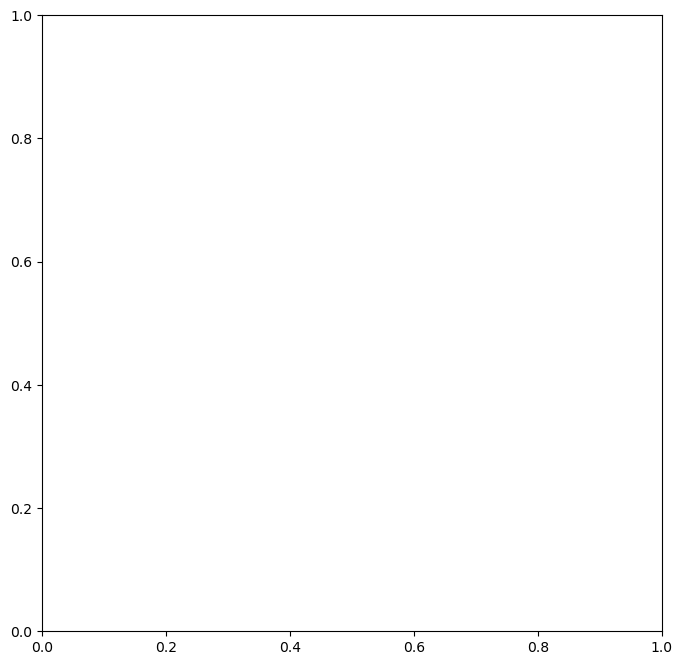

In [ ]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(1000, *imgshape).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), # x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()


savedir = f"{saveroot}/MNIST_UNet_CNN_EDM"
os.makedirs(savedir, exist_ok=True)
device = get_device()
Xtsr = (mnist_Xtsr.to(device) - 0.5) / 0.5
pnts = Xtsr.view(Xtsr.shape[0], -1)
imgshape = Xtsr.shape[1:]
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"MNIST dataset {pnts.shape[0]} samples, {ndim} features")
config = edict(
    channels=1,
    img_size=32,
    layers_per_block=1,
    attn_resolutions=[0],
    model_channels=16,
    channel_mult=[1,2,3,4],
    dropout=0.13,
    label_dim=0,
    augment_dim=0,
)
unet = create_unet_model(config)
model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(Xtsr, model_precd, edm_loss_fn, 
                                    lr=0.001, nepochs=1000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=5)

noise_init = torch.randn(1000, *imgshape).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

x_traj.shape
scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None, None, None] * x_traj).cpu()

plt.figure(figsize=[8, 8])
plt.imshow(to_imgrid((x_out.cpu()[:64]+1)/2, nrow=8, padding=1))
plt.title("Learned samples")
plt.show()

# plt.plot(scaled_x_traj[:, ::4, 0, 0, 0].numpy(), 
#         scaled_x_traj[:, ::4, 0, 0, 1].numpy(), lw=0.5, color="k", alpha=0.5)
# plt.scatter(scaled_x_traj[-1,:,0,0,0], scaled_x_traj[-1,:,0,0,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
# plt.scatter(scaled_x_traj[ 0,:,0,0,0], scaled_x_traj[ 0,:,0,0,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
# plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
# plt.axis("equal")
# plt.legend()
# plt.show()

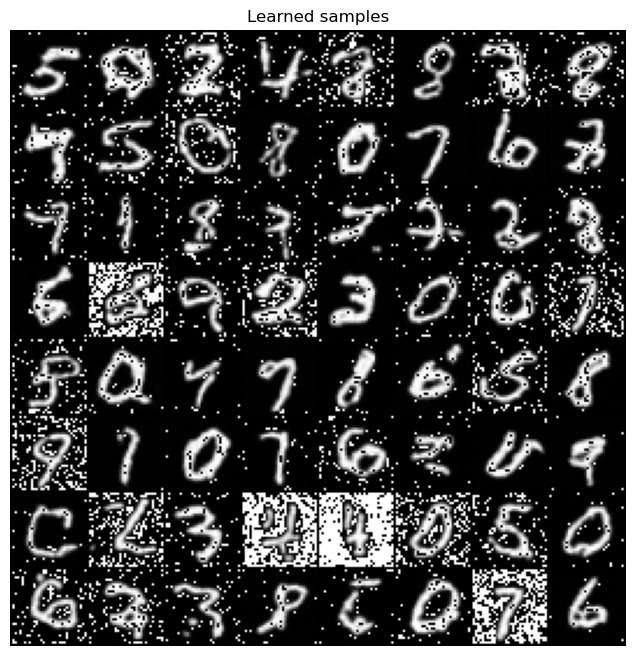

In [ ]:
plt.figure(figsize=[8, 8])
plt.imshow(to_imgrid((x_out.cpu()[:64]+1)/2, nrow=8, padding=1))
plt.axis("off")
plt.title("Learned samples")
plt.show()

In [ ]:
pkl.dump(sample_store, open(f"{savedir}/sample_store.pkl", "wb"))
pkl.dump(loss_store, open(f"{savedir}/loss_store.pkl", "wb"))
torch.save(model_precd.model.state_dict(), f"{savedir}/model_final.pth")
# pkl.dump({"diag_var": diag_var.cpu(), 
#           "rot": rot.cpu(), 
#           "cov": cov.cpu(), 
#           "cov_empirical": cov_empirical.cpu(),
#           "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

#### Analyze the dynamics of spectral space

In [ ]:
true_cov_eigs = diag_var.cpu()
mean_x_sample_traj = []
cov_x_sample_traj = []
diag_cov_x_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final = x_final.to(device).view(x_final.shape[0], -1)
    mean_x_sample = x_final.mean(dim=0)
    mean_x_sample_traj.append(mean_x_sample.cpu())
    cov_x_sample = torch.cov(x_final.T)
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_sample_true_eigenbasis = rot.T @ cov_x_sample @ rot
    diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
    diag_cov_x_sample_true_eigenbasis_traj.append(diag_cov_x_sample_true_eigenbasis.cpu())
    cov_x_sample_traj.append(cov_x_sample.cpu())
    
mean_x_sample_traj = torch.stack(mean_x_sample_traj).cpu()
cov_x_sample_traj = torch.stack(cov_x_sample_traj).cpu()
diag_cov_x_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_sample_true_eigenbasis_traj).cpu()

pkl.dump({"diag_cov_x_sample_true_eigenbasis_traj": diag_cov_x_sample_true_eigenbasis_traj.cpu(), 
          "mean_x_sample_traj": mean_x_sample_traj.cpu(),
          "cov_x_sample_traj": cov_x_sample_traj.cpu(),
          "true_cov_eigs": true_cov_eigs.cpu(),
          "step_slice": step_slice}, open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "wb"))

  0%|          | 0/201 [00:00<?, ?it/s]

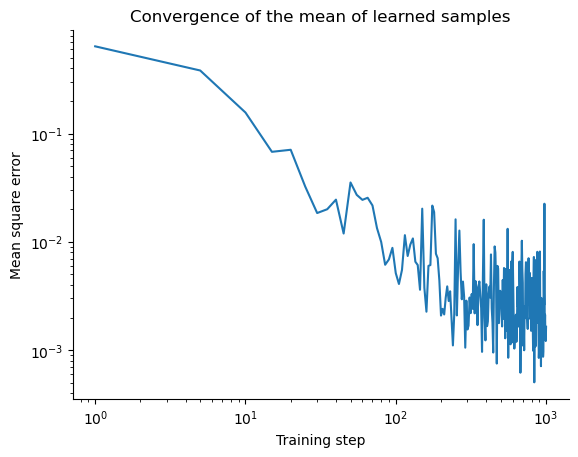

In [ ]:
# plot the convergence of the mean 
mean_X_loss = (mean_x_sample_traj.cuda() - X_mean).pow(2).mean(dim=1)
plt.plot(step_slice, mean_X_loss.cpu().numpy(), label="MSE of mean")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Mean square error")
plt.title("Convergence of the mean of learned samples")
saveallforms(savedir, "sample_mean_convergence_MSE_traj")
plt.show()

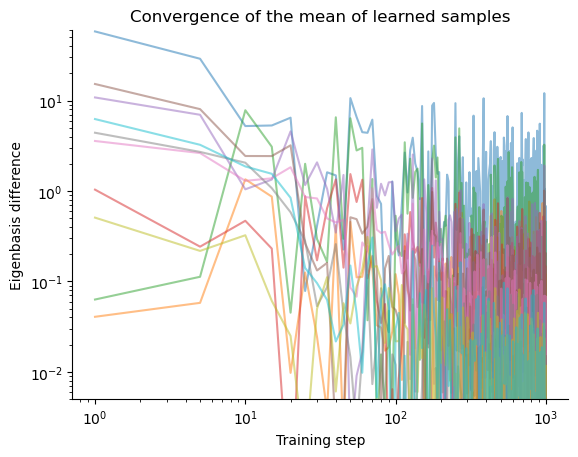

In [ ]:
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.cuda() - X_mean) @ rot
plt.plot(step_slice, mean_X_diff_true_basis.pow(2).cpu().numpy()[:, slice(None, 20, 2)], label="Eigenbasis difference", alpha=0.5)
plt.ylim(5E-3, None)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Eigenbasis difference")
plt.title("Convergence of the mean of learned samples")
# saveallforms(savedir, "sample_mean_convergence_MSE_traj")
plt.show()

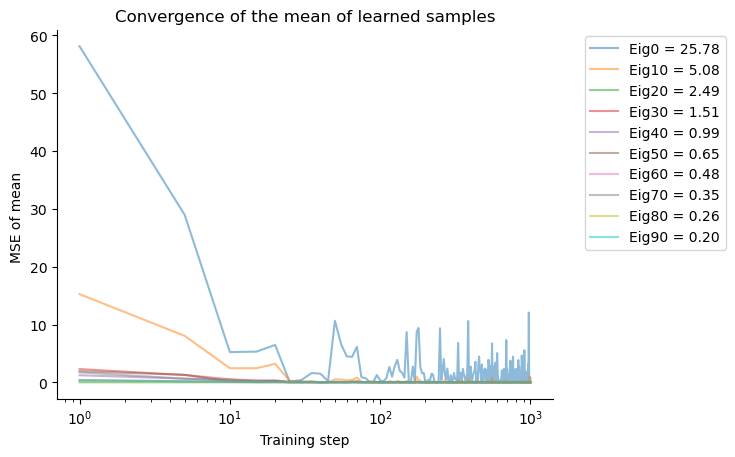

In [ ]:
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.cuda() - X_mean) @ rot
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("MSE of mean ")
plt.title("Convergence of the mean of learned samples")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, "sample_mean_convergence_eigenbasis_MSE_traj_top100")
plt.show()

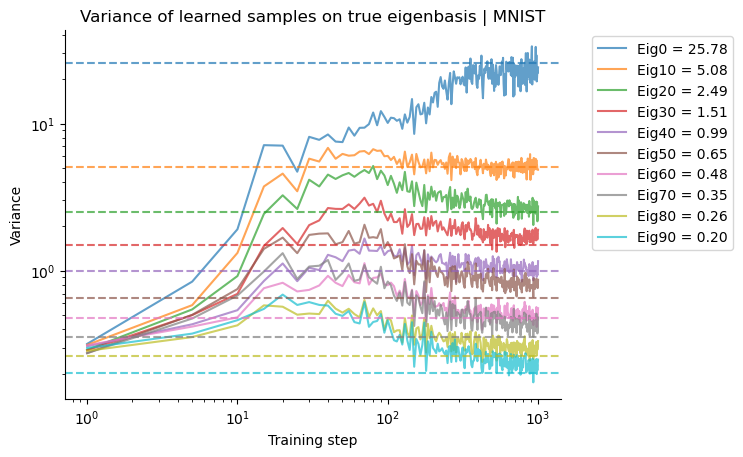

In [ ]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top100")
plt.show()

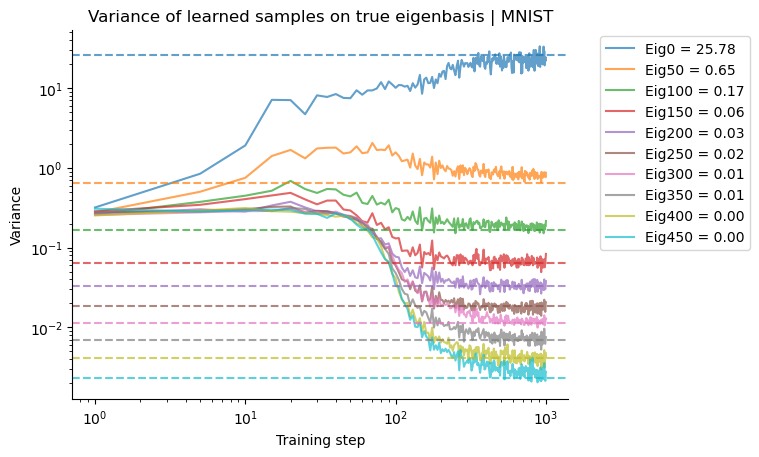

In [ ]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top500")
plt.show()

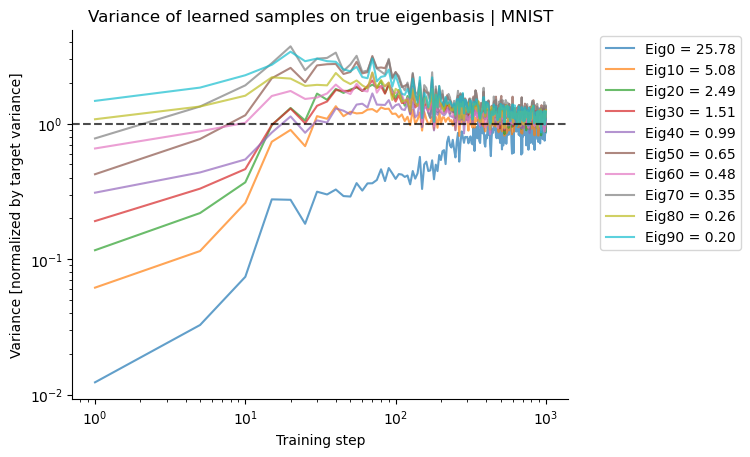

In [ ]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top100")
plt.show()

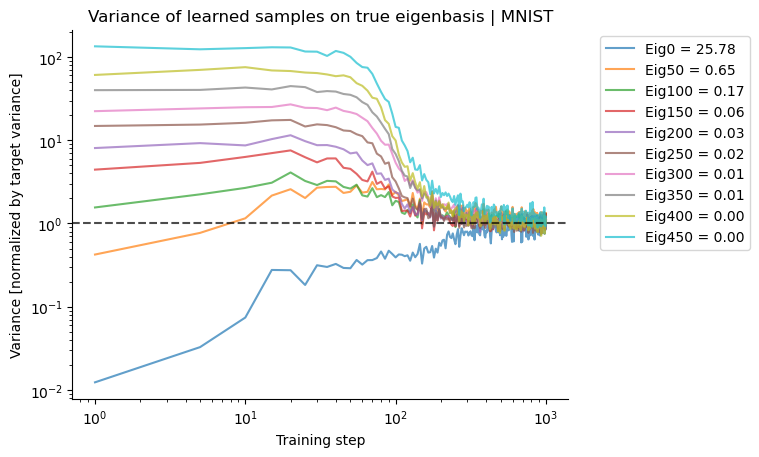

In [ ]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top500")
plt.show()

### Alternative Convolutional Architecture

In [ ]:
import json
from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid

In [ ]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(1000, *imgshape).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), # x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()


savedir = f"{saveroot}/MNIST_UNet_CNN_EDM_shallow"
os.makedirs(savedir, exist_ok=True)
device = get_device()
Xtsr = (mnist_Xtsr.to(device) - 0.5) / 0.5
pnts = Xtsr.view(Xtsr.shape[0], -1)
imgshape = Xtsr.shape[1:]
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"MNIST dataset {pnts.shape[0]} samples, {ndim} features")
config = edict(
    channels=1,
    img_size=32,
    layers_per_block=2,
    attn_resolutions=[0],
    model_channels=32,
    channel_mult=[1,2],
    dropout=0.0,
    label_dim=0,
    augment_dim=0,
)
json.dump(config, open(f"{savedir}/config.json", "w"))
unet = create_unet_model(config)
model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(Xtsr, model_precd, edm_loss_fn, 
                                    lr=0.001, nepochs=5000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=5)

noise_init = torch.randn(1000, *imgshape).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None, None, None] * x_traj).cpu()

plt.figure(figsize=[8, 8])
plt.imshow(to_imgrid((x_out.cpu()[:64]+1)/2, nrow=8, padding=1))
plt.title("Learned samples")
plt.show()

MNIST dataset 60000 samples, 1024 features
total number of trainable parameters in the Score Model: 982049
total number of parameters in the Score Model: 982049


  0%|          | 0/5000 [00:00<?, ?it/s]

step 0 loss 1.934


KeyboardInterrupt: 

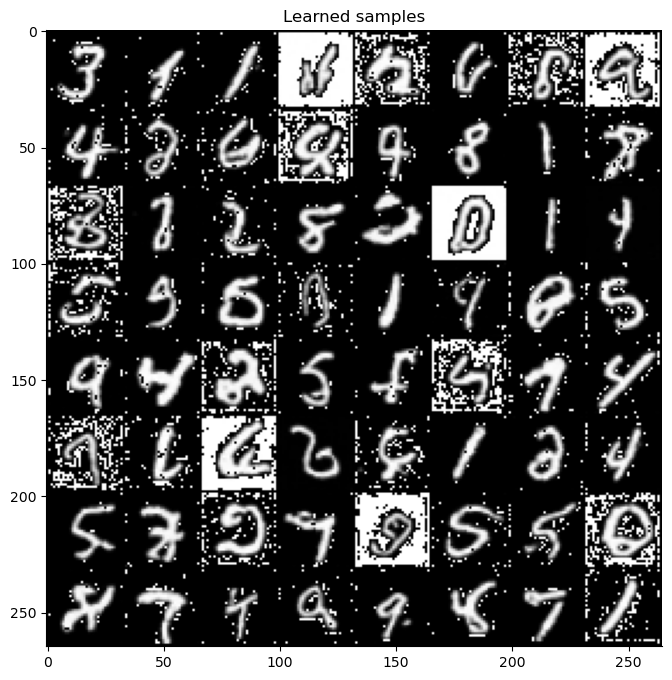

In [ ]:
noise_init = torch.randn(64, *imgshape).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None, None, None] * x_traj).cpu()

plt.figure(figsize=[8, 8])
plt.imshow(to_imgrid((x_out.cpu()[:64]+1)/2, nrow=8, padding=1))
plt.title("Learned samples")
plt.show()

In [ ]:
savedir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_shallow'

In [ ]:
pkl.dump(sample_store, open(f"{savedir}/sample_store.pkl", "wb"))
pkl.dump(loss_store, open(f"{savedir}/loss_store.pkl", "wb"))
torch.save(model_precd.model.state_dict(), f"{savedir}/model_final.pth")
# pkl.dump({"diag_var": diag_var.cpu(), 
#           "rot": rot.cpu(), 
#           "cov": cov.cpu(), 
#           "cov_empirical": cov_empirical.cpu(),
#           "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

In [ ]:
savedir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_shallow'

In [ ]:
ndim = pnts.shape[1]
X_mean = pnts.mean(dim=0)
cov_empirical = torch.cov(pnts.T, correction=1)
# diagonalize the covariance matrix
cov_empirical_eigs, cov_empirical_evecs = torch.linalg.eigh(cov_empirical)
cov_empirical_eigs = cov_empirical_eigs.flip(0)
cov_empirical_evecs = cov_empirical_evecs.flip(1)
rot = cov_empirical_evecs
diag_var = cov_empirical_eigs
assert torch.allclose(rot @ torch.diag(diag_var) @ rot.T, cov_empirical, atol=5e-5)
pkl.dump({"diag_var": diag_var.cpu(), 
          "rot": rot.cpu(), 
          #   "cov": cov.cpu(), 
          "cov_empirical": cov_empirical.cpu(),
          "X_mean": X_mean.cpu(),
          "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

In [ ]:
true_cov_eigs = diag_var.cpu()
mean_x_sample_traj = []
cov_x_sample_traj = []
diag_cov_x_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final = x_final.to(device).view(x_final.shape[0], -1)
    mean_x_sample = x_final.mean(dim=0)
    mean_x_sample_traj.append(mean_x_sample.cpu())
    cov_x_sample = torch.cov(x_final.T)
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_sample_true_eigenbasis = rot.T @ cov_x_sample @ rot
    diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
    diag_cov_x_sample_true_eigenbasis_traj.append(diag_cov_x_sample_true_eigenbasis.cpu())
    cov_x_sample_traj.append(cov_x_sample.cpu())
    
mean_x_sample_traj = torch.stack(mean_x_sample_traj).cpu()
cov_x_sample_traj = torch.stack(cov_x_sample_traj).cpu()
diag_cov_x_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_sample_true_eigenbasis_traj).cpu()

pkl.dump({"diag_cov_x_sample_true_eigenbasis_traj": diag_cov_x_sample_true_eigenbasis_traj.cpu(), 
          "mean_x_sample_traj": mean_x_sample_traj.cpu(),
          "cov_x_sample_traj": cov_x_sample_traj.cpu(),
          "true_cov_eigs": true_cov_eigs.cpu(),
          "step_slice": step_slice}, open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "wb"))

  0%|          | 0/204 [00:00<?, ?it/s]

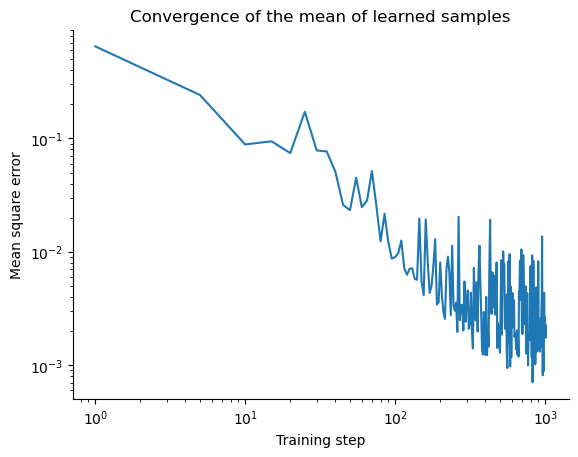

In [ ]:
# plot the convergence of the mean 
mean_X_loss = (mean_x_sample_traj.cuda() - X_mean).pow(2).mean(dim=1)
plt.plot(step_slice, mean_X_loss.cpu().numpy(), label="MSE of mean")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Mean square error")
plt.title("Convergence of the mean of learned samples")
saveallforms(savedir, "sample_mean_convergence_MSE_traj")
plt.show()

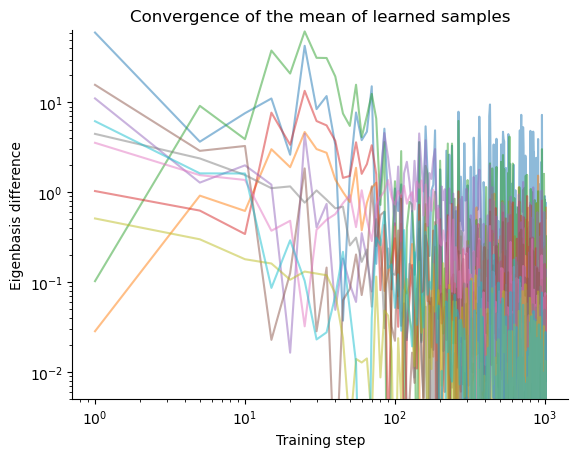

In [ ]:
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.cuda() - X_mean) @ rot
plt.plot(step_slice, mean_X_diff_true_basis.pow(2).cpu().numpy()[:, slice(None, 20, 2)], label="Eigenbasis difference", alpha=0.5)
plt.ylim(5E-3, None)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Eigenbasis difference")
plt.title("Convergence of the mean of learned samples")
# saveallforms(savedir, "sample_mean_convergence_MSE_traj")
plt.show()

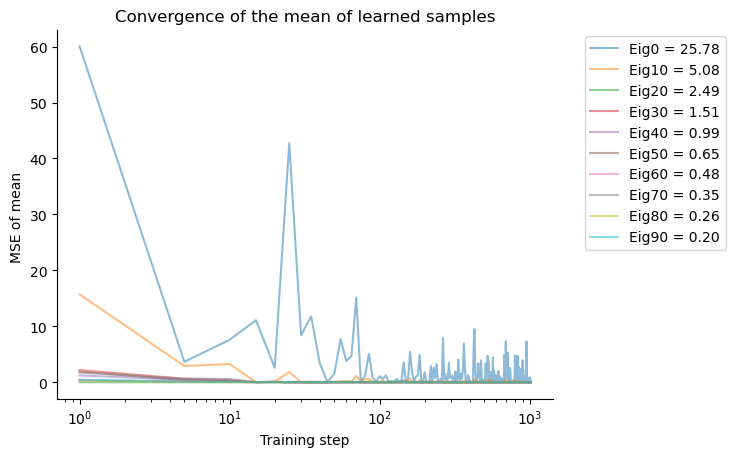

In [ ]:
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.cuda() - X_mean) @ rot
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("MSE of mean ")
plt.title("Convergence of the mean of learned samples")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, "sample_mean_convergence_eigenbasis_MSE_traj_top100")
plt.show()

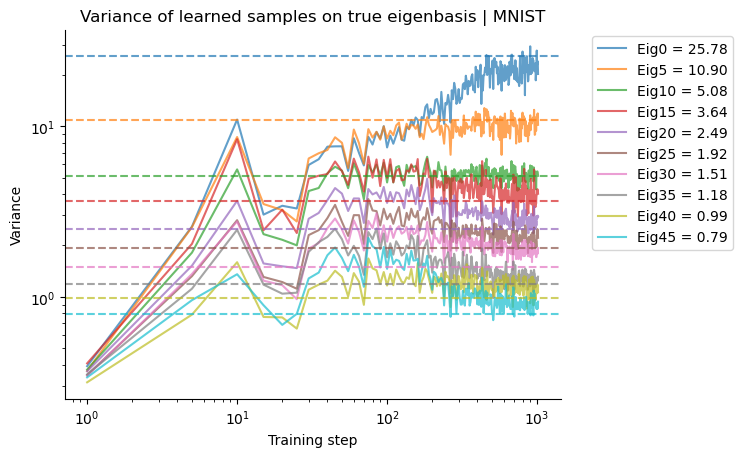

In [ ]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 50, 5)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top50")
plt.show()

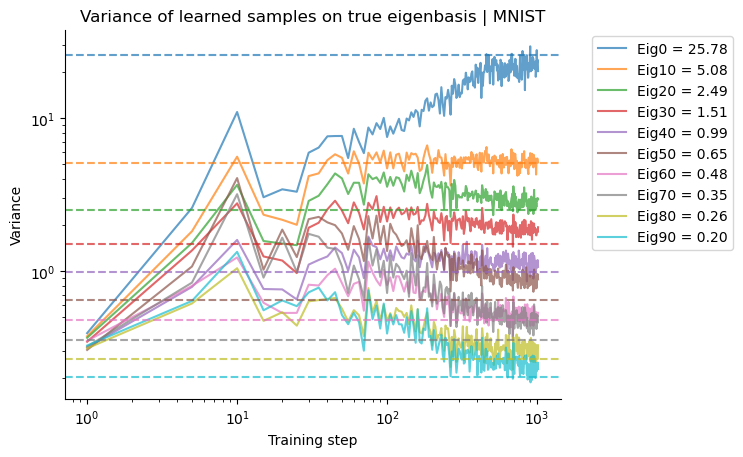

In [ ]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top100")
plt.show()

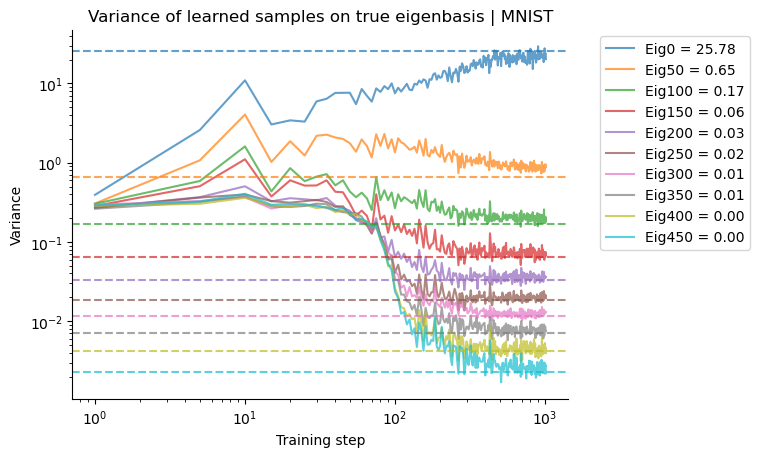

In [ ]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top500")
plt.show()

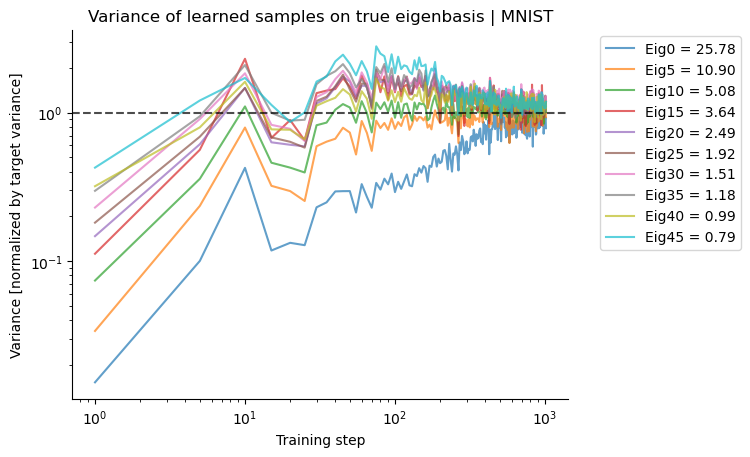

In [ ]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 50, 5)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top50")
plt.show()

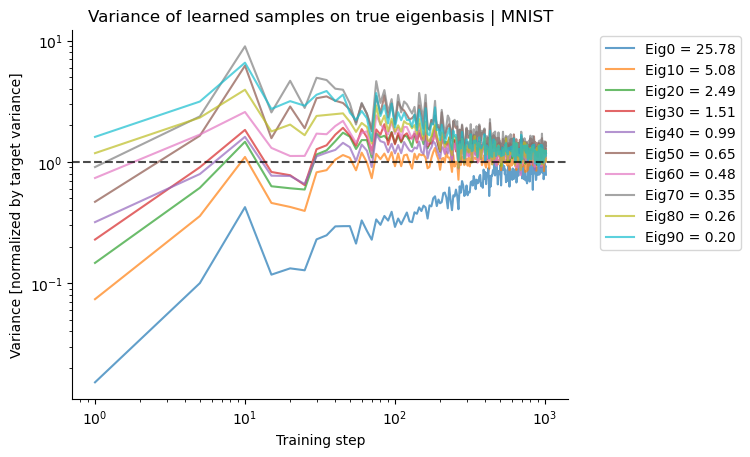

In [ ]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top100")
plt.show()

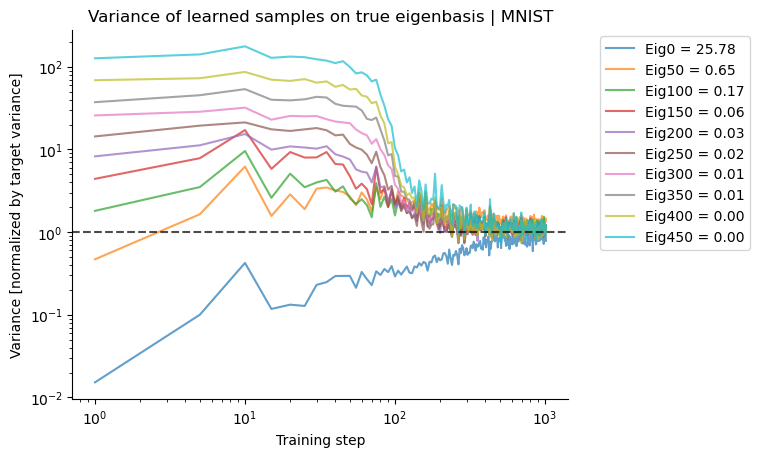

In [ ]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top500")
plt.show()

### Alternative Convolutional Architecture NO Attention

In [18]:
import json
from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid

In [19]:
torch.cuda.empty_cache()

MNIST dataset 60000 samples, 1024 features
total number of trainable parameters in the Score Model: 214753
total number of parameters in the Score Model: 214753


  0%|          | 0/1000 [00:00<?, ?it/s]

step 0 loss 1.937


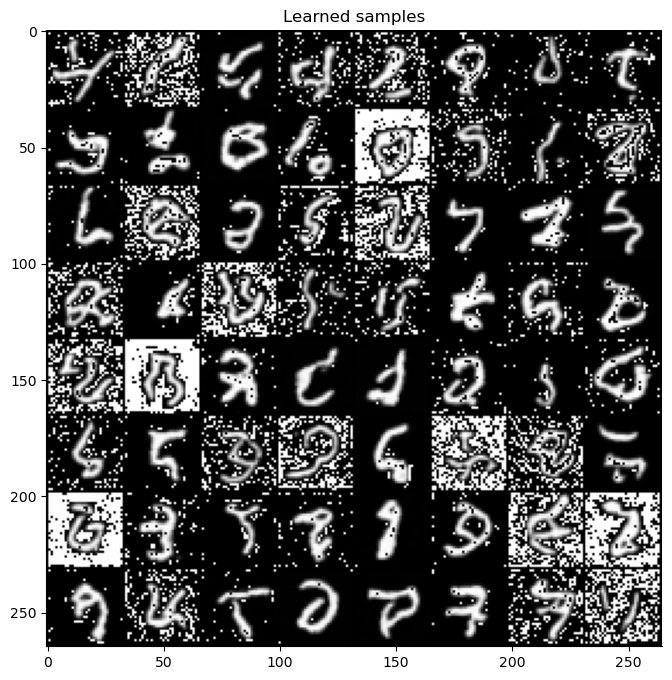

In [20]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(1000, *imgshape).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), # x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()


savedir = f"{saveroot}/MNIST_UNet_CNN_EDM_shallow_1block_noattn"
os.makedirs(savedir, exist_ok=True)
device = get_device()
Xtsr = (mnist_Xtsr.to(device) - 0.5) / 0.5
pnts = Xtsr.view(Xtsr.shape[0], -1)
imgshape = Xtsr.shape[1:]
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"MNIST dataset {pnts.shape[0]} samples, {ndim} features")
config = edict(
    channels=1,
    img_size=32,
    layers_per_block=2,
    attn_resolutions=[],
    decoder_init_attn=False,
    model_channels=32,
    channel_mult=[1,],
    dropout=0.0,
    label_dim=0,
    augment_dim=0,
)
json.dump(config, open(f"{savedir}/config.json", "w"))
unet = create_unet_model(config)
model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(Xtsr, model_precd, edm_loss_fn, 
                                    lr=0.001, nepochs=1000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=5)

noise_init = torch.randn(1000, *imgshape).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None, None, None] * x_traj).cpu()

plt.figure(figsize=[8, 8])
plt.imshow(to_imgrid((x_out.cpu()[:64]+1)/2, nrow=8, padding=1))
plt.title("Learned samples")
plt.show()

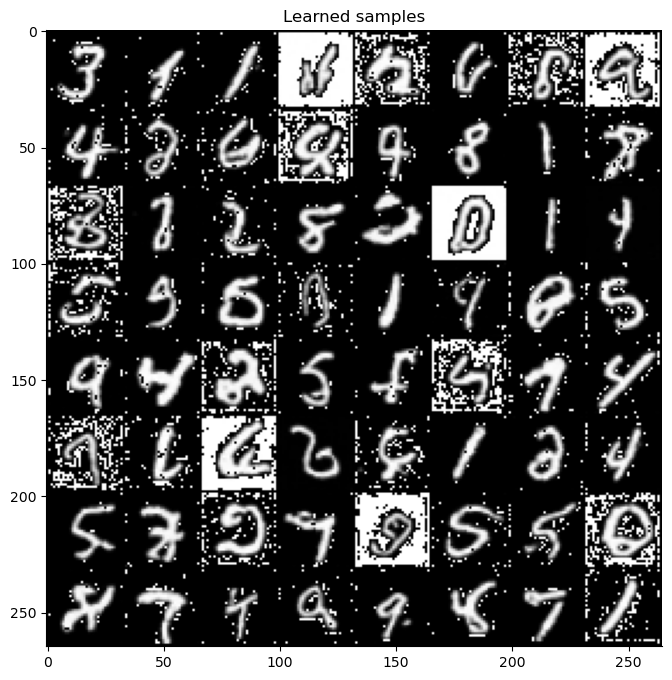

In [ ]:
noise_init = torch.randn(64, *imgshape).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None, None, None] * x_traj).cpu()

plt.figure(figsize=[8, 8])
plt.imshow(to_imgrid((x_out.cpu()[:64]+1)/2, nrow=8, padding=1))
plt.title("Learned samples")
plt.show()

In [21]:
pkl.dump(sample_store, open(f"{savedir}/sample_store.pkl", "wb"))
pkl.dump(loss_store, open(f"{savedir}/loss_store.pkl", "wb"))
torch.save(model_precd.model.state_dict(), f"{savedir}/model_final.pth")
# pkl.dump({"diag_var": diag_var.cpu(), 
#           "rot": rot.cpu(), 
#           "cov": cov.cpu(), 
#           "cov_empirical": cov_empirical.cpu(),
#           "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

In [22]:
savedir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_shallow_1block_noattn'

In [23]:
true_cov_eigs = diag_var.cpu()
mean_x_sample_traj = []
cov_x_sample_traj = []
diag_cov_x_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final = x_final.to(device).view(x_final.shape[0], -1)
    mean_x_sample = x_final.mean(dim=0)
    mean_x_sample_traj.append(mean_x_sample.cpu())
    cov_x_sample = torch.cov(x_final.T)
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_sample_true_eigenbasis = rot.T @ cov_x_sample @ rot
    diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
    diag_cov_x_sample_true_eigenbasis_traj.append(diag_cov_x_sample_true_eigenbasis.cpu())
    cov_x_sample_traj.append(cov_x_sample.cpu())
    
mean_x_sample_traj = torch.stack(mean_x_sample_traj).cpu()
cov_x_sample_traj = torch.stack(cov_x_sample_traj).cpu()
diag_cov_x_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_sample_true_eigenbasis_traj).cpu()

pkl.dump({"diag_cov_x_sample_true_eigenbasis_traj": diag_cov_x_sample_true_eigenbasis_traj.cpu(), 
          "mean_x_sample_traj": mean_x_sample_traj.cpu(),
          "cov_x_sample_traj": cov_x_sample_traj.cpu(),
          "true_cov_eigs": true_cov_eigs.cpu(),
          "step_slice": step_slice}, open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "wb"))

  0%|          | 0/201 [00:00<?, ?it/s]

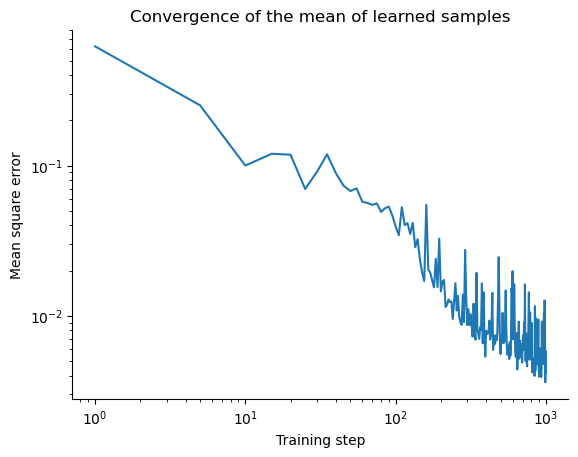

In [24]:
# plot the convergence of the mean 
mean_X_loss = (mean_x_sample_traj.to(device) - X_mean).pow(2).mean(dim=1)
plt.plot(step_slice, mean_X_loss.cpu().numpy(), label="MSE of mean")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Mean square error")
plt.title("Convergence of the mean of learned samples")
saveallforms(savedir, "sample_mean_convergence_MSE_traj")
plt.show()

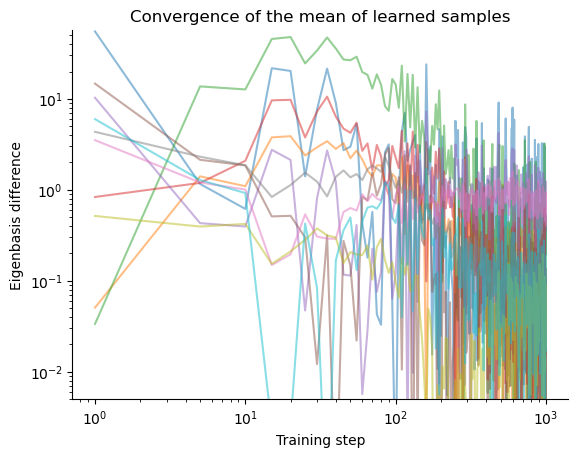

In [25]:
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.to(device) - X_mean) @ rot
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 20, 2)
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.ylim(5E-3, None)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Eigenbasis difference")
plt.title("Convergence of the mean of learned samples")
# saveallforms(savedir, "sample_mean_convergence_MSE_traj")
plt.show()

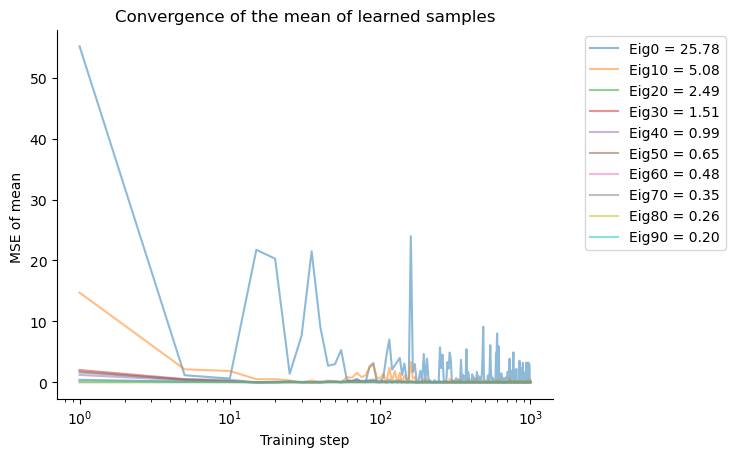

In [26]:
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.cuda() - X_mean) @ rot
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("MSE of mean ")
plt.title("Convergence of the mean of learned samples")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, "sample_mean_convergence_eigenbasis_MSE_traj_top100")
plt.show()

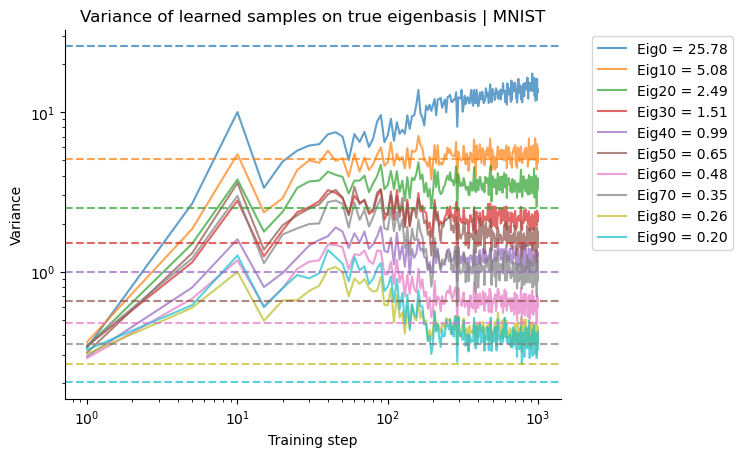

In [27]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top100")
plt.show()

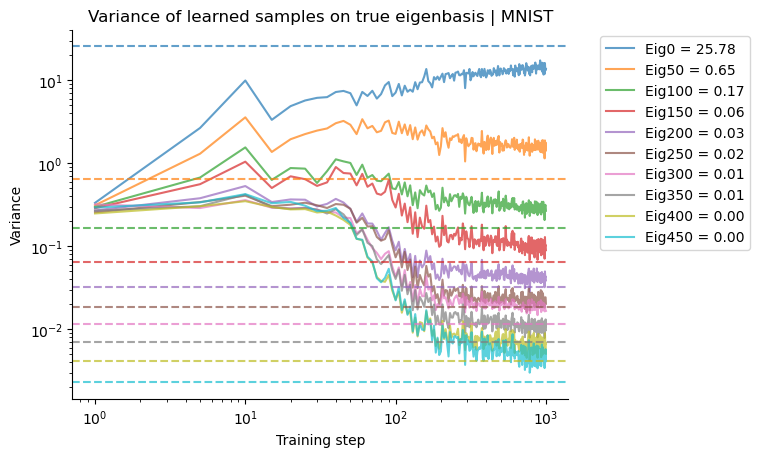

In [28]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top500")
plt.show()

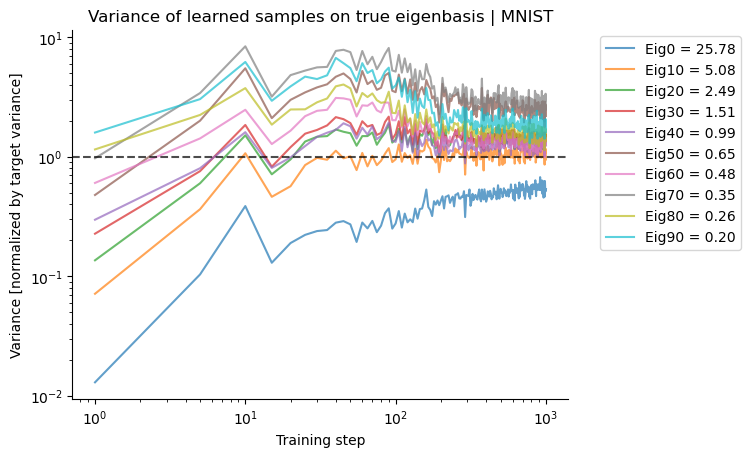

In [29]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top100")
plt.show()

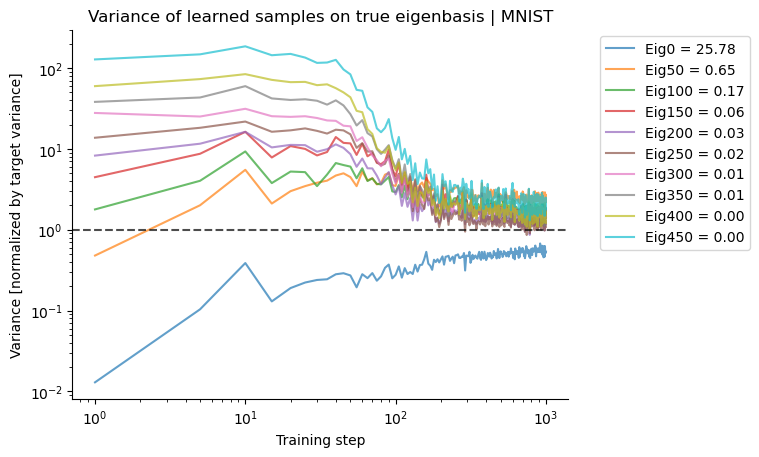

In [30]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top500")
plt.show()

### Alternative CNN architecture

MNIST dataset 60000 samples, 1024 features
total number of trainable parameters in the Score Model: 1474209
total number of parameters in the Score Model: 1474209


  0%|          | 0/1000 [00:00<?, ?it/s]

step 0 loss 1.937


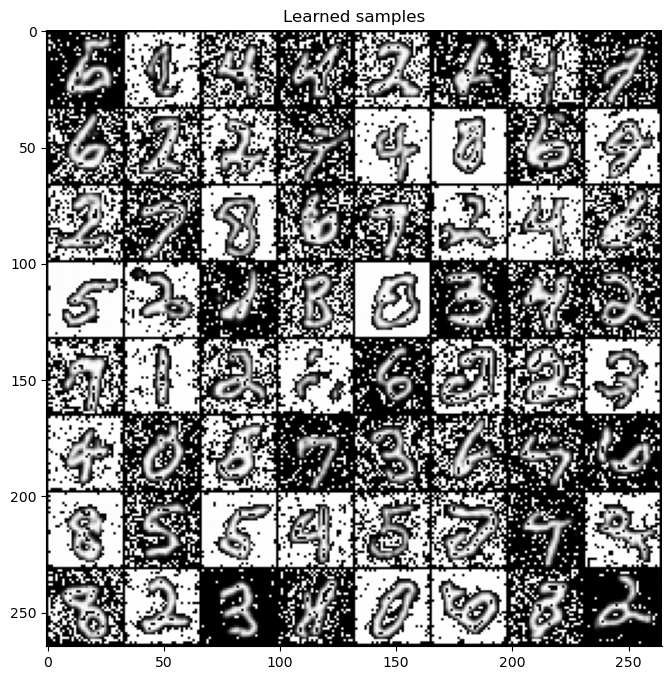

In [31]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(1000, *imgshape).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), # x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()


savedir = f"{saveroot}/MNIST_UNet_CNN_EDM_deeper_1block_noattn"
os.makedirs(savedir, exist_ok=True)
device = get_device()
Xtsr = (mnist_Xtsr.to(device) - 0.5) / 0.5
pnts = Xtsr.view(Xtsr.shape[0], -1)
imgshape = Xtsr.shape[1:]
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"MNIST dataset {pnts.shape[0]} samples, {ndim} features")
config = edict(
    channels=1,
    img_size=32,
    layers_per_block=1,
    attn_resolutions=[],
    decoder_init_attn=False,
    model_channels=16,
    channel_mult=[1,2,3,4,4],
    dropout=0.0,
    label_dim=0,
    augment_dim=0,
)
json.dump(config, open(f"{savedir}/config.json", "w"))
unet = create_unet_model(config)
model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(Xtsr, model_precd, edm_loss_fn, 
                                    lr=0.001, nepochs=1000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=5)

noise_init = torch.randn(1000, *imgshape).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None, None, None] * x_traj).cpu()

plt.figure(figsize=[8, 8])
plt.imshow(to_imgrid(((x_out.cpu()[:64]+1)/2).clamp(0, 1), nrow=8, padding=1))
plt.title("Learned samples")
plt.show()

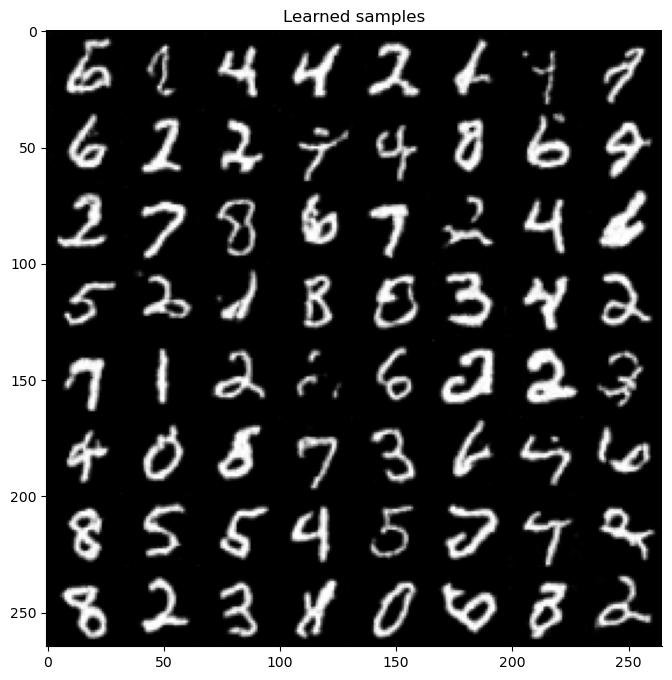

In [33]:
plt.figure(figsize=[8, 8])
plt.imshow(to_imgrid(((x_out.cpu()[:64]+1)/2).clamp(0, 1), nrow=8, padding=1))
plt.title("Learned samples")
plt.show()

In [34]:
savedir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_deeper_1block_noattn'

In [49]:
!du -sh /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/GaussianData/ndim128/*

4.0K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/GaussianData/ndim128/loss_store.pkl
360K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/GaussianData/ndim128/model_final.pth
32K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/GaussianData/ndim128/sample_cov_true_eigenbasis_diag_traj_normalized_every10.pdf
84K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/GaussianData/ndim128/sample_cov_true_eigenbasis_diag_traj_normalized_every10.png
28K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/GaussianData/ndim128/sample_cov_true_eigenbasis_diag_traj_normalized_top10.pdf
76K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/GaussianData/ndim128/sample_cov_true_eigenbasis_

In [35]:
pkl.dump(sample_store, open(f"{savedir}/sample_store.pkl", "wb"))
pkl.dump(loss_store, open(f"{savedir}/loss_store.pkl", "wb"))
torch.save(model_precd.model.state_dict(), f"{savedir}/model_final.pth")
# pkl.dump({"diag_var": diag_var.cpu(), 
#           "rot": rot.cpu(), 
#           "cov": cov.cpu(), 
#           "cov_empirical": cov_empirical.cpu(),
#           "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

In [36]:
true_cov_eigs = diag_var.cpu()
mean_x_sample_traj = []
cov_x_sample_traj = []
diag_cov_x_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final = x_final.to(device).view(x_final.shape[0], -1)
    mean_x_sample = x_final.mean(dim=0)
    mean_x_sample_traj.append(mean_x_sample.cpu())
    cov_x_sample = torch.cov(x_final.T)
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_sample_true_eigenbasis = rot.T @ cov_x_sample @ rot
    diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
    diag_cov_x_sample_true_eigenbasis_traj.append(diag_cov_x_sample_true_eigenbasis.cpu())
    cov_x_sample_traj.append(cov_x_sample.cpu())
    
mean_x_sample_traj = torch.stack(mean_x_sample_traj).cpu()
cov_x_sample_traj = torch.stack(cov_x_sample_traj).cpu()
diag_cov_x_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_sample_true_eigenbasis_traj).cpu()

pkl.dump({"diag_cov_x_sample_true_eigenbasis_traj": diag_cov_x_sample_true_eigenbasis_traj.cpu(), 
          "mean_x_sample_traj": mean_x_sample_traj.cpu(),
          "cov_x_sample_traj": cov_x_sample_traj.cpu(),
          "true_cov_eigs": true_cov_eigs.cpu(),
          "step_slice": step_slice}, open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "wb"))

  0%|          | 0/201 [00:00<?, ?it/s]

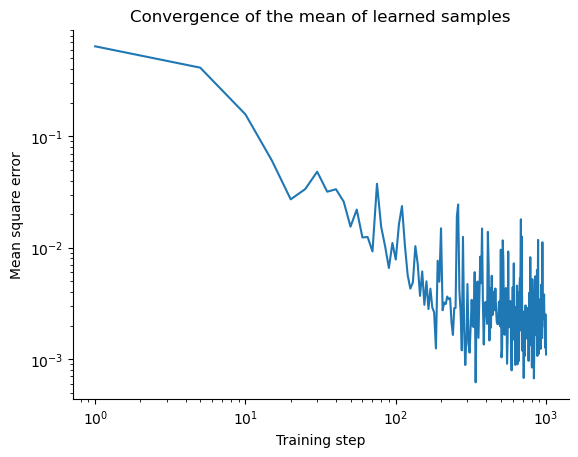

In [37]:
# plot the convergence of the mean 
mean_X_loss = (mean_x_sample_traj.to(device) - X_mean).pow(2).mean(dim=1)
plt.plot(step_slice, mean_X_loss.cpu().numpy(), label="MSE of mean")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Mean square error")
plt.title("Convergence of the mean of learned samples")
saveallforms(savedir, "sample_mean_convergence_MSE_traj")
plt.show()

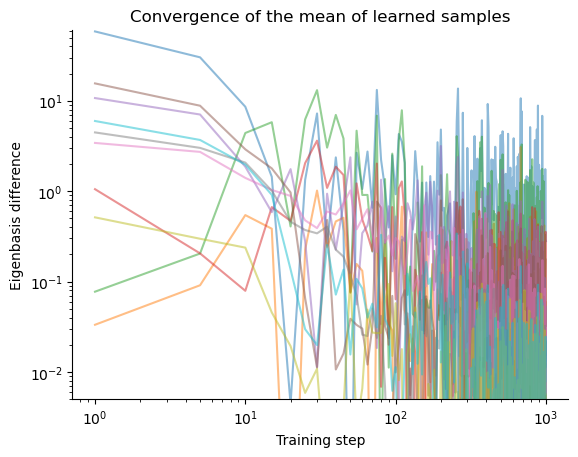

In [38]:
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.to(device) - X_mean) @ rot
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 20, 2)
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.ylim(5E-3, None)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Eigenbasis difference")
plt.title("Convergence of the mean of learned samples")
# saveallforms(savedir, "sample_mean_convergence_MSE_traj")
plt.show()

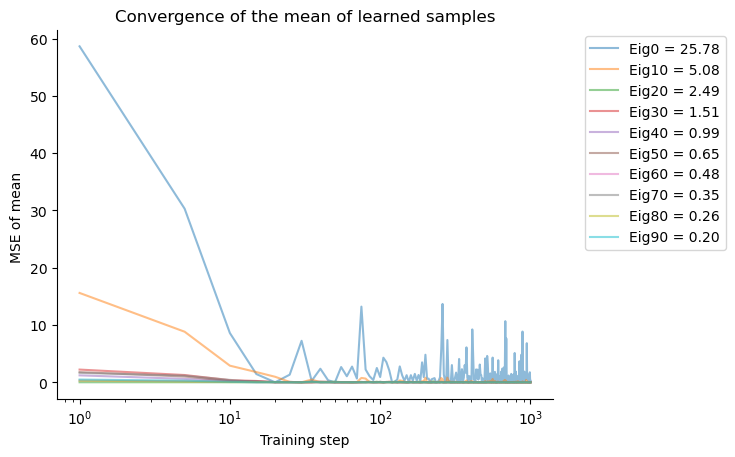

In [39]:
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.to(device) - X_mean) @ rot
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("MSE of mean ")
plt.title("Convergence of the mean of learned samples")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, "sample_mean_convergence_eigenbasis_MSE_traj_top100")
plt.show()

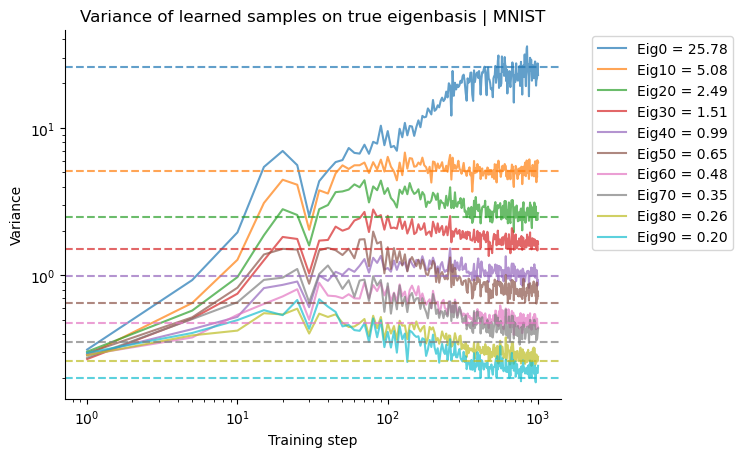

In [40]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top100")
plt.show()

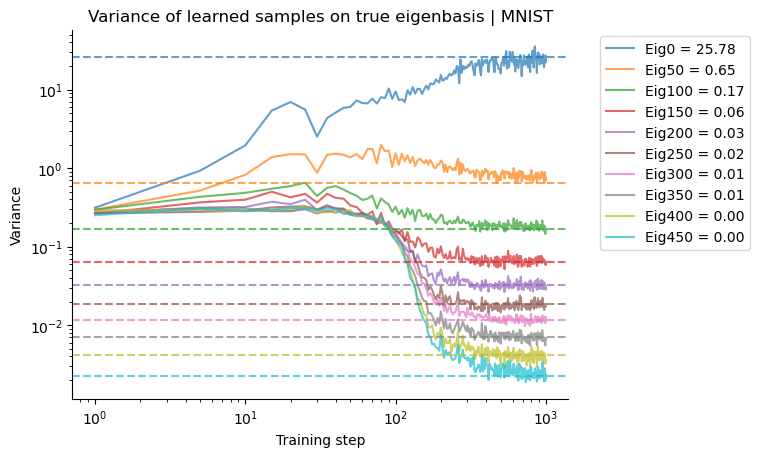

In [42]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top500")
plt.show()

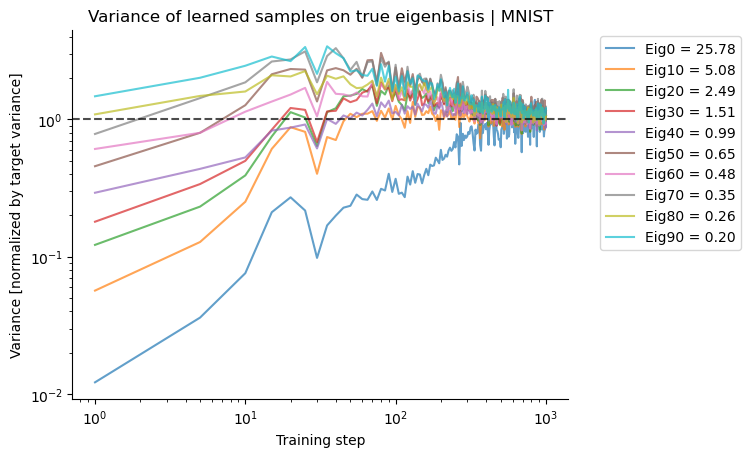

In [43]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top100")
plt.show()

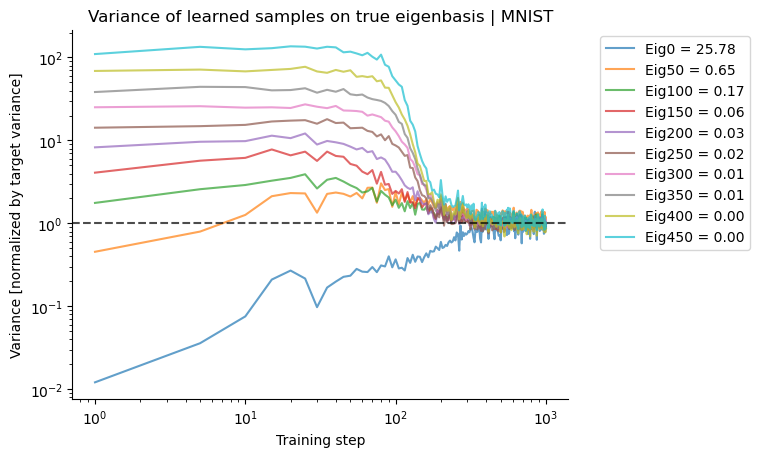

In [44]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 500, 50)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top500")
plt.show()

## Scratch

In [ ]:
config = edict(
    channels=1,
    img_size=32,
    layers_per_block=1,
    attn_resolutions=[0],
    model_channels=16,
    channel_mult=[1,2,3,4],
)
unet = SongUNet(in_channels=config.channels, 
                out_channels=config.channels, 
                num_blocks=config.layers_per_block, 
                attn_resolutions=config.attn_resolutions, 
                model_channels=config.model_channels, 
                channel_mult=config.channel_mult, 
                dropout=0.13, 
                img_resolution=config.img_size, 
                label_dim=0,
                embedding_type='positional', 
                encoder_type='standard', 
                decoder_type='standard', 
                augment_dim=0, #  no augmentation , 9 for defaults. 
                channel_mult_noise=1, 
                resample_filter=[1,1], 
                )